# Automated Pneumonia Detection Using Chest X-Ray Images

**This project determines that the user is Pneumonia Positive or Pneumonia Negative on the basis of Chest X-Ray.**

In [ ]:
!pip install pyyaml h5py

In [ ]:
!pip install anvil-uplink

     |████████████████████████████████| 64 kB 2.8 MB/s 
     |████████████████████████████████| 51 kB 157 kB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45230 sha256=48b0bbbbb555866575d799853ee9e5424f68b9bd7a163fb545198902063bea67
  Stored in directory: /root/.cache/pip/wheels/29/ea/7d/3410aa0aa0e4402ead9a7a97ab2214804887e0f5c2b76f0c96
Successfully built ws4py


In [ ]:
import anvil.server

In [ ]:
anvil.server.connect("CAIVB2KP6QYCQ7FNRHCY2U76-RGYPVGDW4VFGKXYL")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


#Import libraries and Dataset 

In [ ]:
from fastai.vision import *

In [ ]:
from fastai.metrics import error_rate, accuracy
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path

In [ ]:
path = Path('/content/drive/My Drive/Colab Notebooks/X-Ray Image Dataset')

**View all files in directory**

In [ ]:
path.ls()

[PosixPath('/content/drive/My Drive/Colab Notebooks/X-Ray Image Dataset/Train'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/X-Ray Image Dataset/Valid')]

In [ ]:
import numpy as np

In [ ]:
np.random.seed(41)
data = ImageDataBunch.from_folder(path, train="Train", valid ="Valid",
        ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['No-Findings', 'Pneumonia'], 2, 160, 40)

**Training Data consists of 80 Pneumonic images labeled as "Pneumonia" and 80 non-pneumonic Negative images labeled as "No-Findings"**

**Validation Data consists of 20 Pneumonic images labeled as "Pneumonia" and 20 non-pneumonic images labeled as "No-Findings"**

In [ ]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 160
Number of examples in validation: 40


In [ ]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

**Sample images from the dataset**

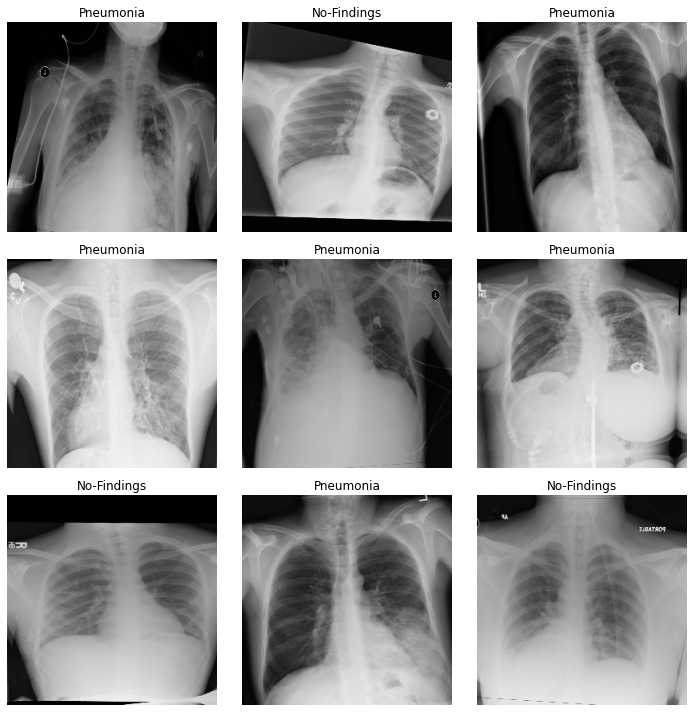

In [ ]:
data.show_batch(rows=3, figsize=(10,10))

# DarkCovidNet (modified Darknet model)

In [ ]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [ ]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [ ]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [ ]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 2),
    Flatten(),
    nn.Linear(338, 2)
)

In [ ]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [ ]:
learn.fit_one_cycle(100, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.756809,0.693271,0.500000,00:40
1,0.717975,0.693499,0.500000,00:19
2,0.690709,0.693845,0.500000,00:19
3,0.652728,0.694347,0.500000,00:19
4,0.622010,0.734054,0.500000,00:20
5,0.586757,0.969968,0.500000,00:19
6,0.558975,0.967424,0.500000,00:19
7,0.530291,0.961528,0.600000,00:19
8,0.511182,0.611710,0.800000,00:19
9,0.485462,0.532871,0.775000,00:19


**Training and Validation Loss**

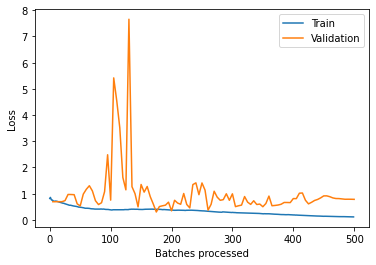

In [ ]:
learn.recorder.plot_losses()

**Save the Model**

In [ ]:
learn.save('weights.h5')

In [ ]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid)

In [ ]:
accuracy(probs,targets)

tensor(0.7000)

**Out of 40, 33 are correctly identified and only 7 are wrongly identified**

In [ ]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print('Probs', len(probs), 'Correct', correct,'Accuracy', accuracy)

Probs 40 Correct 28 Accuracy 0.7


In [ ]:
from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) 
cm1 = confusion_matrix(targets, probs)
print("Confusion Matrix")
print(cm1)

Confusion Matrix
[[14  6]
 [ 6 14]]


In [ ]:
from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Pneumonia', 'No-Findings']
print("Classification Report")
print(classification_report(y_true1, y_pred1, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    Covid-19       0.70      0.70      0.70        20
 No-Findings       0.70      0.70      0.70        20

    accuracy                           0.70        40
   macro avg       0.70      0.70      0.70        40
weighted avg       0.70      0.70      0.70        40



Confusion Matrix


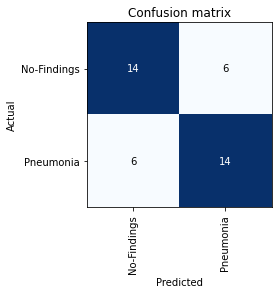

In [ ]:
print("Confusion Matrix")
interp = ClassificationInterpretation.from_learner(learn)
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import PIL
import numpy as np

In [ ]:
def get_prediction(test_img):
    """Evaluate the model on a PIL image"""
    test_img = test_img.resize((128,128), resample=PIL.Image.BICUBIC)
    test_arr = img_to_array(test_img)
    test_arr = np.expand_dims(test_arr, axis=0)
    test_arr /= 255.0
    
    return model.predict(test_arr)

In [ ]:
import anvil.media

@anvil.server.callable
def classify_image(file):
  with anvil.media.TempFile(file) as f:
    img = load_img(f)
  
  model = load_model("/content/drive/My Drive/Colab Notebooks/X-Ray Image Dataset/models/weights.h5")
  score = get_prediction(img)

  return score, 'Normal' if score < 0.5 else 'Pneumonia'

In [ ]:
anvil.server.wait_forever()

KeyboardInterrupt: ignored